# Machine Translation Project (English to French)

In [11]:
import collections
import numpy as np
import json

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Activation, TimeDistributed, RepeatVector
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

# Verify Access to the GPU

In [2]:
def load_data(path):
    input_file = path
    with open(input_file, "r") as f:
        data = f.read()
    return data.split('\n')

english_sentences = load_data('data/english')
french_sentences = load_data('data/french')

### Dataset 

For our Machine  Translation project, we opt for a dataset featuring a limited vocabulary, specifically designed to faciliate a more manageble and efficient training process. Unlike the extensive WMT datasets, our chosen dataset ensures a quicker training time and demands fewer computational resources. This strategic decision aims to balance the learning experience while still achieving meaningful results within practical time constraints   

### Load Data

In [3]:
def load_data(path):
    input_file=path
    with open(input_file,'r') as f:
        data=f.read()
    return data.split('\n')

english_sentences=load_data('data/english')
french_sentences=load_data('data/french')

### Load Sample

In [4]:
english_sentences[:5]

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .']

By examining the sentences, it's apparent that they have undergone preprocessing: punctuation has been delimited with spaces, and all the text has been converted to lowercase. This preprocessing serves a crucial purpose in text preparation. Firstly, delimiting punctuation with spaces ensures that each punctuation mark is treated as a separate token, aiding the model in understanding sentence structure. Secondly, converting the entire text to lowercase standardizes the input, preventing the model from distinguishing between words solely based on their casing. This uniformity facilitates more effective training and generalization, enhancing the model's ability to grasp patterns and generate accurate translations.

### Structure Of Dataset

In [5]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')

print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


### Preprocess 
1) Tokenize the words into ids
2) Add padding to make all the sequences the same length

In [6]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']

text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [7]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')

test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [8]:
def preprocess(x,y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    
    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


### Models
1) Model 1 is a simple RNN
2) Model 2 is a Bidirectional RNN
3) Model 3 is an Embedding RNN

#### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [9]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

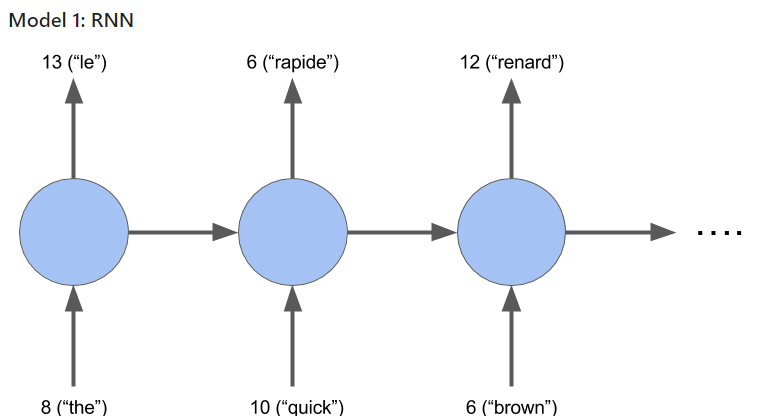

A basic RNN model is a good baseline for sequence data. In this model, you'll build a RNN that translates English to French.

In [15]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    #Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

#Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 183s 2s/step - loss: 1.9528 - accuracy: 0.5426 - val_loss: 1.2853 - val_accuracy: 0.6365
Epoch 2/10
108/108 [==============================] - 200s 2s/step - loss: 1.2329 - accuracy: 0.6414 - val_loss: 1.0865 - val_accuracy: 0.6775
Epoch 3/10
108/108 [==============================] - 219s 2s/step - loss: 1.0921 - accuracy: 0.6686 - val_loss: 0.9818 - val_accuracy: 0.6862
Epoch 4/10
108/108 [==============================] - 178s 2s/step - loss: 1.0096 - accuracy: 0.6837 - val_loss: 0.9272 - val_accuracy: 0.7040
Epoch 5/10
108/108 [==============================] - 216s 2s/step - loss: 0.9583 - accuracy: 0.6908 - val_loss: 0.8775 - val_accuracy: 0.7103
Epoch 6/10
108/108 [==============================] - 218s 2s/step - loss: 0.9076 - accuracy: 0.7027 - val_loss: 0.8172 - val_accuracy: 0.7271
Epoch 7/10
108/108 [==============================] - 211s 2s/step - loss: 0.8819 - accuracy: 0.7053 - val_loss: 0.8072 - val_accuracy: 0.7247

In [16]:
# Print prediction(s)
print("Predicton:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print('\nOriginal text:')
print(english_sentences[:1])

Predicton:
1/1 [==============================] - 1s 1s/step
new jersey est parfois calme en mois de mai et il est en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


### Bidirectional RNNs

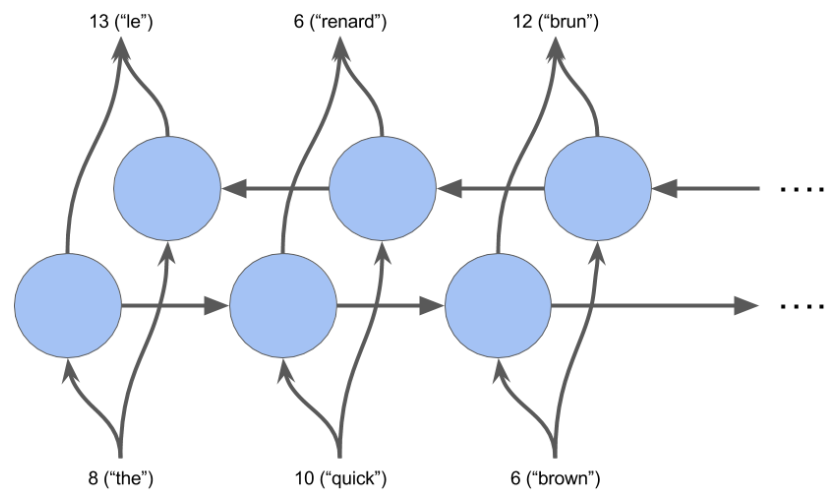

One restriction of a RNN is that it can't see the future input, only the past. This is where bidirectional recurrent neural networks come in. They are able to see the future data.

In [17]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    #Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
bd_rnn_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(bd_rnn_model.summary())
bd_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 21, 256)          100608    
 nal)                                                            
                                                                 
 time_distributed_10 (TimeDi  (None, 21, 1024)         263168    
 stributed)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_11 (TimeDi  (None, 21, 345)          353625    
 stributed)                                                      
                                                                 
Total params: 717,401
Trainable params: 717,401
Non-trainable params: 0
________________________________________________

In [18]:
# Print prediction(s)
print("Prediciton:")
print(logits_to_text(bd_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print('\nOriginal text:')
print(english_sentences[:1])

Prediciton:
1/1 [==============================] - 1s 1s/step
new jersey est parfois chaud en mois de il et il en en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


### Model 3: Embedding

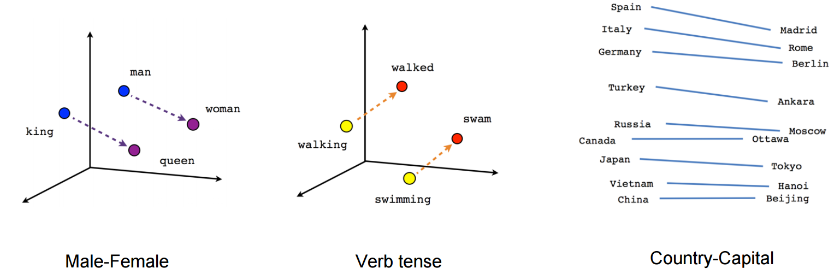

You've turned the words into ids, but there's a better representation of a word. This is called word embeddings. An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In [21]:
def bidirectional_embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    # Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size+1, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# Build the model
embed_rnn_model = bidirectional_embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(embed_rnn_model.summary())

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 256)           51200     
                                                                 
 bidirectional_4 (Bidirectio  (None, 21, 512)          789504    
 nal)                                                            
                                                                 
 time_distributed_16 (TimeDi  (None, 21, 1024)         525312    
 stributed)                                                      
                                                                 
 dropout_8 (Dropout)         (None, 21, 1024)          0         
                                                                 
 time_distributed_17 (TimeDi  (None, 21, 345)          353625    
 stributed)                                                      
                                                      

In [22]:
# Print prediction(s)
print("Prediciton:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print('\nOriginal text:')
print(english_sentences[:1])

Prediciton:
1/1 [==============================] - 6s 6s/step
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


In [23]:
embed_rnn_model.save('english_to_french_model')
# Serialize English Tokenizer to JSON
with open('english_tokenizer.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(english_tokenizer.to_json(), ensure_ascii=False))
    
# Serialize French Tokenizer to JSON
with open('french_tokenizer.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(french_tokenizer.to_json(), ensure_ascii=False))
    
# Save max lengths
max_french_sequence_length_json = max_french_sequence_length
with open('sequence_length.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(max_french_sequence_length_json, ensure_ascii=False))

INFO:tensorflow:Assets written to: english_to_french_model\assets


INFO:tensorflow:Assets written to: english_to_french_model\assets
